<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_MoGVAE(MSE%2BCD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 30.2 MB/s eta 0:00:00


In [ ]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "mogvae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/mogvae_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
vae_models.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
mogvae_models.py downloaded successfully.


In [ ]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import vae_models
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import mogvae_models
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from vae_models import standVAE
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data
from mogvae_models import MoGVAE

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.74 GB


In [ ]:
import torch
import torch.optim as optim
import numpy as np



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data(file_names, num_points=num_points, device=device)
print(len(data_loader))
# MoGVAEモデル構築
vae = MoGVAE(n_in_out=3 * num_points, n_z=3, n_components=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=5e-6)

9


In [ ]:
epochs = 7500
interval = 100

rec_error_record = []
reccd_error_record = []
reg_error_record = []
total_error_record = []
z_list = []
for i in range(epochs):
    vae.train()
    loss_mse = 0
    loss_cd = 0
    loss_reg = 0
    loss_total = 0

    for k, (x,) in enumerate(data_loader):
        # xをdeviceに移動
        x = x.to(device)
        x = x.squeeze(0)

        # VAEの出力と損失を計算
        y, z = vae(x)
        lrec, lcd, lreg = vae.loss2(y, x)  # Chamfer, MSE, KL_D losses

        # エポック数の半分までは定数、以降で線形補間する
        half_epoch = epochs // 2
        if i < half_epoch:
            alpha = 1.0
            beta  = 0.0
        else:
            # 補間の進捗度 progress は 0〜1 の範囲
            #progress = (i - half_epoch) / (epochs - half_epoch - 1)
            alpha = 0.6 # 1.0 - progress
            beta  = 0.4 # progress

        # 損失の合計を計算
        loss = alpha * lrec + beta * lcd + lreg
        loss_mse += lrec.item()
        loss_cd += lcd.item()
        loss_reg += lreg.item()
        loss_total += loss.item()

        # 最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 最終エポックで z を収集
        if i == epochs - 1:
            z_list.append(z.cpu().detach().numpy())

    # 各ミニバッチでの平均損失を計算
    loss_mse /= (k + 1)
    loss_cd  /= (k + 1)
    loss_reg /= (k + 1)
    loss_total /= (k + 1)

    # ログ記録
    rec_error_record.append(loss_mse)
    reccd_error_record.append(loss_cd)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    # 指定間隔でのログ出力
    if i % interval == 0:
        print(f"Epoch:{i} loss_mse:{loss_mse} loss_cd:{loss_cd} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

# 最終エポック後に z_list を保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")


Epoch:0 loss_mse:5804.984266493056 loss_cd:1.0741727881961398 Loss_Reg:0.004792273044586182 Loss_Total:5804.989095052083
Epoch:100 loss_mse:1168.954338921441 loss_cd:0.20071837057669958 Loss_Reg:65.09330452813043 Loss_Total:1234.0476684570312
Epoch:200 loss_mse:1143.7063802083333 loss_cd:0.1968652539783054 Loss_Reg:31.609046088324654 Loss_Total:1175.3154432508682
Epoch:300 loss_mse:1144.745137532552 loss_cd:0.19485923647880554 Loss_Reg:24.227116054958767 Loss_Total:1168.9722493489583
Epoch:400 loss_mse:1152.5250108506943 loss_cd:0.2047348933087455 Loss_Reg:24.18709225124783 Loss_Total:1176.7120903862847
Epoch:500 loss_mse:1153.4632771809895 loss_cd:0.20302987098693848 Loss_Reg:22.064836502075195 Loss_Total:1175.528103298611
Epoch:600 loss_mse:1151.1489935980903 loss_cd:0.19370989501476288 Loss_Reg:20.200017505221897 Loss_Total:1171.3490125868057
Epoch:700 loss_mse:1144.4025539822048 loss_cd:0.19462274511655173 Loss_Reg:19.786582946777344 Loss_Total:1164.1891411675347
Epoch:800 loss_mse

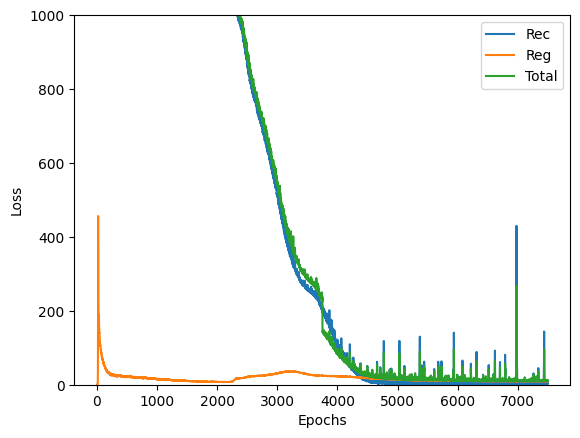

Model weights have been saved!


In [ ]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/MoGVAE_Np5000_CD_0222.pth')
print("Model weights have been saved!")

In [ ]:
print(z_list) # z mu logvar

[array([ 1.0273505,  2.1474006, -1.8842692], dtype=float32), array([-0.71963   ,  2.5593882 ,  0.86624044], dtype=float32), array([1.5665901, 0.9767067, 2.6019256], dtype=float32), array([ 0.13520995,  0.6939568 , -2.6953907 ], dtype=float32), array([-1.2104713 ,  2.6476543 , -0.80036175], dtype=float32), array([ 1.0147483, -1.7667882,  2.1045246], dtype=float32), array([-0.520644  , -0.38940582,  2.799686  ], dtype=float32), array([0.5798911, 1.9338465, 1.7782307], dtype=float32), array([ 1.4766445, -1.1679791, -2.8305173], dtype=float32)]


# 再構成形状の可視化

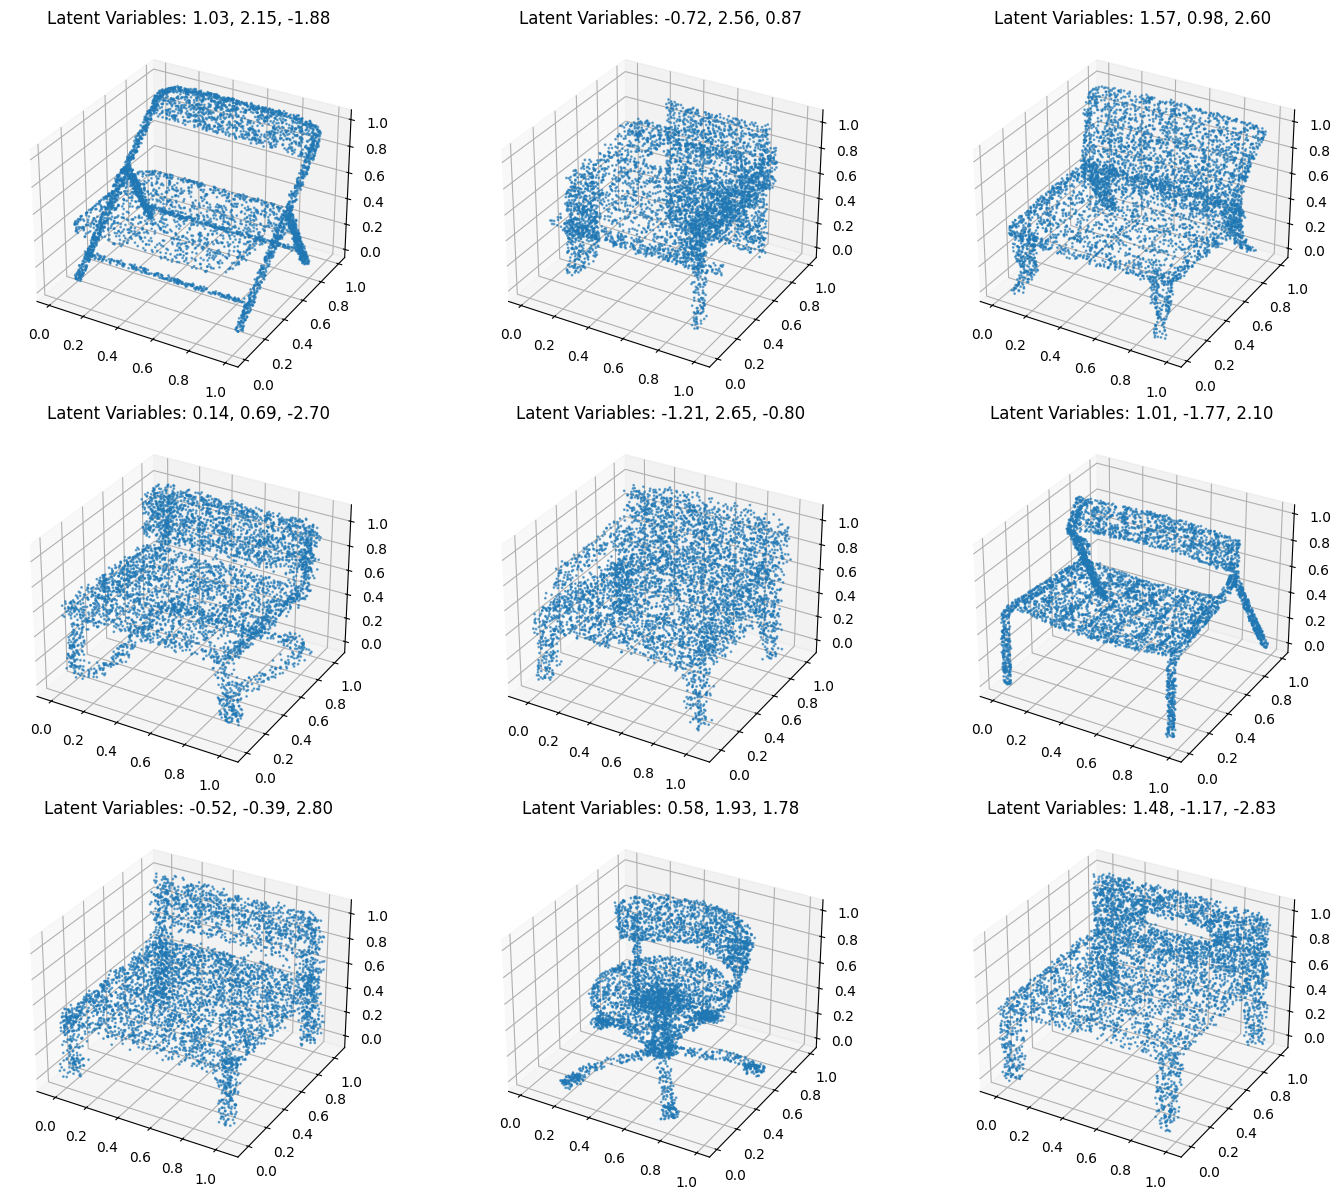

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = vae.decode(z)  # z をバッチの形状に変換

    # CPU上で detach して numpy に変換
    reconst = recon_batch.cpu().detach().numpy().reshape(-1)

    # num_points に基づいて点群を分割
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# 再構成誤差チェック using CD

Chamfer Distances: [0.19128869473934174, 0.12568798661231995, 0.15497846901416779, 0.1373342126607895, 0.14478057622909546, 0.20218592882156372, 0.17214930057525635, 0.1344480961561203, 0.16077879071235657]
Average Chamfer Distance: 0.1581813395023346


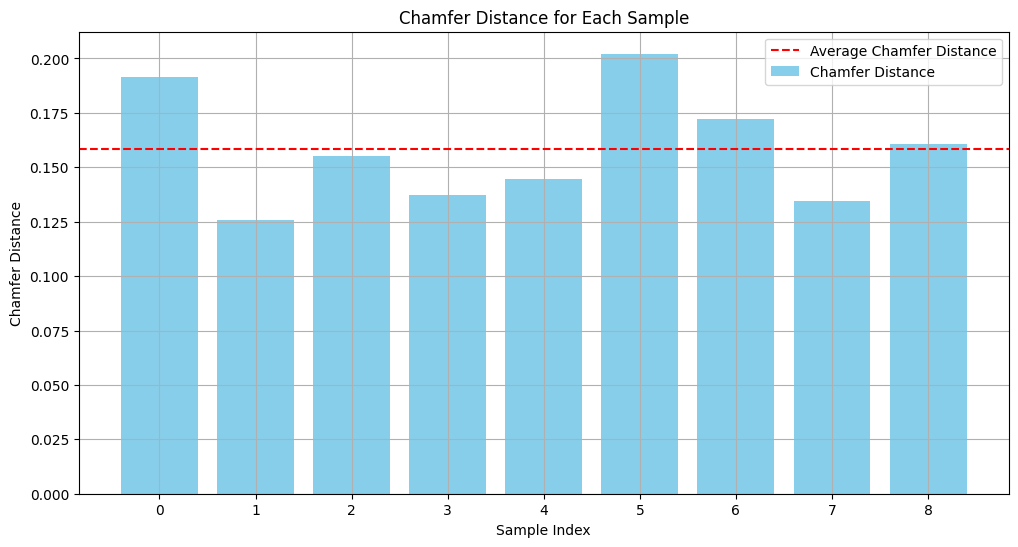

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

tensor([ 1.0274,  2.1474, -1.8843], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


tensor([-0.7196,  2.5594,  0.8662], device='cuda:0')
tensor([1.5666, 0.9767, 2.6019], device='cuda:0')
tensor([ 0.1352,  0.6940, -2.6954], device='cuda:0')
tensor([-1.2105,  2.6477, -0.8004], device='cuda:0')
tensor([ 1.0147, -1.7668,  2.1045], device='cuda:0')
tensor([-0.5206, -0.3894,  2.7997], device='cuda:0')
tensor([0.5799, 1.9338, 1.7782], device='cuda:0')
tensor([ 1.4766, -1.1680, -2.8305], device='cuda:0')
EMD Distances: [0.21391489914134879, 0.15261764855127177, 0.183801496229399, 0.17734899535536117, 0.18843608979268064, 0.21267382898512038, 0.20947462646375703, 0.1539867994476189, 0.21967283457780606]
Average EMD Distance: 0.1902141353938182


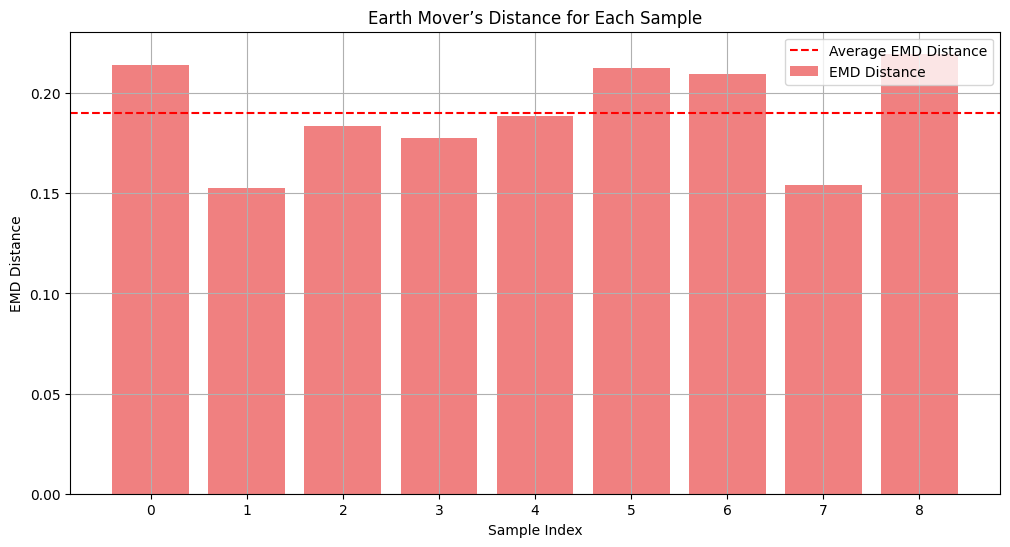

In [ ]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    print(z_list[i])
    recon_batch = vae.decode(z_list[i])

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
